# Covid-19: From model prediction to model predictive control

## A demo of the deterministic and stochastic, national-level, age-stratified modeling framework

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In `src/covid19model/models.py`, two national-level extended SEIRD compartmental models are coded,
1. COVID19_SEIRD: a deterministic model, using ordinary differential equations (ODEs). The equations are integrated using Scipy's `odeint` with a variable timestep, it is a 'continuous-time' model.
2. COVID19_SEIRD_sto: a stochastic model, using stochastic difference equations (SDEs). The equations are iterated using a fixed timestep of one day and is said to be a 'discrete-time' model.

A third model, a spatially-explicit variant of COVID19_SEIRD_sto is currently being implemented.

The deterministic model was used for all results detailed in our first COVID-19 related preprint: *A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*, which can be found here: https://www.medrxiv.org/content/10.1101/2020.07.17.20156034v2

The documentation given in this tutorial has been redrafted from the above preprint. References have been omitted for the sake of simplicity.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
import scipy
import json
import random

Load the covid 19 custom development code

In [2]:
from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.data import google, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

In [3]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## Introduction

### Model dynamics

The SEIR(D) model was first proposed in 1929 by two Scottish scientists. It is a compartmental model that subdivides the human population into four groups: 1) susceptible individuals, 2) exposed individuals in the latent phase 1, 3) infectious individuals capable of transmitting the disease and 4) individuals removed from the population either through immunization or death. Despite being a simple and idealized reality, the SEIR(D) dynamics are used extensively to predict the outbreak of infectious diseases and this was no different during the SARS-CoV-2 outbreak earlier this year.

In this work, we extend the SEIRD model to incorporate more expert knowledge on SARS-CoV-2. For that purpose, the infectious compartment is split into four parts. The first is a period of presymptomatic infectiousness because several studies have shown that pre-symptomatic transmission is a dominant transmission mechanism of SARS-CoV-2. After the period of pre-symptomatic transmission, three possible infectious outcomes are modeled: (1) Asymptomatic outcome, for individuals who show no symptoms at all, (2) Mild outcome, for individuals with mild symptoms who recover at home, and (3) Hospitalization, when mild symptoms worsen. Children and young adults have a high propensity to experience an asymptomatic or mild outcome, while older individual have a high propensity to be hospitalized.

In general, Belgian hospitals have two wards for COVID-19 patients: 1) Cohort, where patients are not monitored permanently and 2) Intensive care, for patients with the most severe symptoms. Intensive care includes permanent monitoring, the use of ventilators or the use of extracorporeal membrane oxygenation (ECMO). Patients generally spend limited time in the emergency room and/or in a buffer ward before going to Cohort. After spending limited time in Cohort, some patients are transferred to ICU. Patients can perish in both wards, but mortalities are generally lower in Cohort. After a stay in an ICU, patients return to Cohort for recovery in the hospital. During the recovery stay, mortality is limited. The above is a short summary of hospital dynamics based on interviewing Ghent University hospital staff and examining the hospital data.

<img src="../../docs/_static/figs/flowchart_full.png" alt="drawing" width="500"/>

### Model framework and equations

#### Age-stratification

We introduced heterogeneity in the deterministic implementation by means of age-stratification. Every population compartment is split into a number of age classes, the age-groups have different contact rates with other age-groups and the disease progresses differently for each age-group, making the model behaviour more realistic. Our age-stratified model consists of 9 age classes, i.e., [0-10[, [10-20[, [20-30[, [30-40[, [40-50[, [50-60[, [60-70[, [70-80[, [80- $\infty$[. The age-stratified implementation provides a good balance between added complexity and computational resources.

#### Deterministic framework

Our extended SEIRD model is implemented using two frameworks: a deterministic and a stochastic framework. The deterministic equations are obtained by writing down the following equation,

`rate of change = in - out`,

for every of the 11 population compartments. This results in the following system of coupled ordinary differential equations,
\begin{eqnarray}
\dot{S_i} &=& - \beta s_i S_i \sum_{j=1}^{N} N_{c,ij} \Big( \frac{I_j+A_j}{T_j} \Big) + \zeta R_i, \label{eq:system1} \\
\dot{E_i} &=& \beta s_i S_i \sum_{j=1}^{N} N_{c,ij} \Big( \frac{I_j+A_j}{T_j} \Big) - (1/\sigma) \cdot E_i, \label{eq:system2} \\ 
\dot{I_i} &=& (1/\sigma) E_i - (1/\omega) I_i, \label{eq:system3}\\
\dot{A_i} &=& (\text{a}_i/\omega) I_i - (1/d_{\text{a}}) A_i, \label{eq:system4}\\ 
\dot{M_i} &=&  ((1-\text{a}_i) / \omega ) I_i - ( (1-h_i)/d_m + h_i/d_{\text{hospital}} ) M_i,\label{eq:system5} \\
\dot{ER_i} &=& (h_i/d_{\text{hospital}}) M_i - (1/d_{\text{ER}}) ER_i, \label{eq:system6} \\
\dot{C_i} &=& c_i (1/d_{\text{ER}}) ER_i  - (m_{C, i}/d_{c,D}) C_i - ((1 - m_{C, i})/d_{c,R}) C_i, \label{eq:system7} \\
\dot{ICU_i} &=& (1-c_i) (1/d_{\text{ER}}) ER_i - (m_{ICU,i}/d_{\text{ICU},D}) ICU_i  \label{eq:system8} \\
&& - ((1-m_{ICU,i})/d_{\text{ICU},R}) ICU_i, \label{eq:system9}\\
\dot{C}_{\text{ICU,rec,i}} &=& ((1-m_{ICU,i})/d_{\text{ICU},R}) ICU_i - (1/d_{\text{ICU,rec}}) C_{\text{ICU,rec,i}}, \label{eq:system10}\\
\dot{D_i} &=&  (m_{ICU,i}/d_{\text{ICU},D}) ICU_i +  (m_{C,i}/d_{\text{c},D}) C_i , \label{eq:system11}\\
\dot{R_i} &=&  (1/d_a) A_i + ((1-h_i)/d_m) M_i + ((1-m_{C,i})/d_{c,R}) C_i \\
&& + (1/d_{\text{ICU,rec}}) C_{\text{ICU,rec,i}} - \zeta R_i \label{eq:system13},
\end{eqnarray}

for $i = 1,2,...,9$. Here, $T_i$ stands for total population, $S_i$ stands for susceptible, $E_i$ for exposed, $I_i$ for pre-symptomatic and infectious, $A_i$ for asymptomatic and infectious, $M_i$ for mildly symptomatic and infectious, $ER_i$ for emergency room and/or buffer ward, $C_i$ for cohort, $C_{\text{ICU,rec,i}}$ for a recovery stay in Cohort coming from Intensive Care, $ICU_i$ for Intensive Care Unit, $D_i$ for dead and $R_i$ for recovered. Using the above notation, all model states are 9-dimensional vectors,
$$ \mathbf{S} = [S_1(t)\ S_2(t)\ ...\ S_i(t)]^T, $$
where $S_i(t)$ denotes the number of susceptibles in age-class i at time t after the introduction of the virus in the population.

These equations are implemented in the function `COVID19_SEIRD` located in `src/covid19model/models.py`. The integration is performed in `_sim_single` located in `src/covid19model/base.py` by using Scipy's `solve_ivp`. The integrator timestep depends on the rate of change of the system and the solver method is thus referred to as a 'continuous-time' solver. The implementation uses non-integer individuals.

#### Stochastic framework

By defining the probabilities of transitioning (propensities) from one state to another, a system of coupled stochastic difference equations (SDEs) can be obtained. The probability to transition from one state to another is assumed to be exponentially distributed. As an example, consider the average time a patient spends in an ICU when recovering, which is $d_{\text{ICU,R}} = 9.9$ days. The chances of survival in ICU are $(1-m_{\text{ICU,i}})$, where $m_{\text{ICU,i}}$ is the mortality in ICU for an individual in age group $i$. If the probability of transitioning from state ICU to state $C_{\text{ICU,rec}}$ on any given day is assumed to be exponentially distributed, then for an individual in age group $i$,

\begin{equation}
P(ICU_i \rightarrow C_{\text{ICU,rec,i}}) = 1 - \text{exp} \Bigg[ - \frac{1-m_{\text{ICU},i}}{d_{\text{ICU,R}}}\Bigg].
\end{equation}

If a transitioning between states is defined as "succes", we can regard the number of individuals transitioning from ICU to a Cohort recovery ward as a binomial experiment. On a given day, the number of individuals transitioning is,

\begin{equation}
(\text{ICU}_i \rightarrow C_{\text{ICU,rec,i}})(k) \sim \text{Binomial}\Bigg(\text{ICU}_i(k),\ 1 - \text{exp}\Bigg[- \frac{1-m_{\text{ICU,i}}}{d_{\text{ICU,R}}}\Bigg]\Bigg). 
\end{equation}

For a discrete stepsize $l$, there are 15 possible transitions,
\begin{eqnarray}
(S_i \rightarrow E_i) (k) &\sim& \text{Binomial}\Bigg(S_i(k), 1 - \text{exp}\Bigg[- l \beta s_i \sum_{j=1}^{N} N_{c,ij} \Big( \frac{I_j+A_j}{T_j} \Big) \Bigg]\Bigg)\\
(E_i \rightarrow I_i) (k) &\sim& \text{Binomial}\Bigg(E_i(k), 1 - \text{exp}\Bigg[- l\ \frac{1}{\sigma}\Bigg]\Bigg)\\
(I_i \rightarrow A_i) (k) &\sim& \text{Binomial}\Bigg(I_i(k), 1 - \text{exp}\Bigg[- l\ \frac{a_i}{\omega}\Bigg]\Bigg)\\
(I_i \rightarrow M_i) (k) &\sim& \text{Binomial}\Bigg(I_i(k), 1 - \text{exp}\Bigg[- l\ \frac{1-a_i}{\omega}\Bigg]\Bigg)\\
(A_i \rightarrow R_i) (k) &\sim& \text{Binomial}\Bigg(A_i(k), 1 - \text{exp}\Bigg[- l\ \frac{1}{d_a}\Bigg]\Bigg)\\
(M_i \rightarrow R_i) (k) &\sim& \text{Binomial}\Bigg(M_i(k), 1 - \text{exp}\Bigg[- l\ \frac{1-h_i}{d_m}\Bigg]\Bigg)\\
(M_i \rightarrow ER_i) (k) &\sim& \text{Binomial}\Bigg(M_i(k), 1 - \text{exp}\Bigg[- l\ \frac{h_i}{d_{\text{hospital}}}\Bigg]\Bigg)\\
(ER_i \rightarrow C_i) (k) &\sim& \text{Binomial}\Bigg(ER_i(k), 1 - \text{exp}\Bigg[- l\ \frac{c_i}{d_{\text{ER}}}\Bigg]\Bigg)\\
(ER_i \rightarrow ICU_i) (k) &\sim& \text{Binomial}\Bigg(ER_i(k), 1 - \text{exp}\Bigg[- l\ \frac{1-c_i}{d_{\text{ER}}}\Bigg]\Bigg)\\
(C_i \rightarrow R_i) (k) &\sim& \text{Binomial}\Bigg(C_i(k), 1 - \text{exp}\Bigg[- l\ \frac{1-m_{C,i}}{d_{C,R}}\Bigg]\Bigg)\\
(ICU_i \rightarrow C_{\text{ICU,rec,i}}) (k) &\sim& \text{Binomial}\Bigg(ICU_i(k), 1 - \text{exp}\Bigg[- l\ \frac{1-m_{\text{ICU,i}}}{d_{ICU,R}}\Bigg]\Bigg)\\
(C_{\text{ICU,rec,i}} \rightarrow R_i) (k) &\sim& \text{Binomial}\Bigg(C_{\text{ICU,rec,i}}(k), 1 - \text{exp}\Bigg[- l\ \frac{1}{d_{\text{ICU,rec}}}\Bigg]\Bigg)\\
(C_i \rightarrow D_i) (k) &\sim& \text{Binomial}\Bigg(C_i(k), 1 - \text{exp}\Bigg[- l\ \frac{m_{C,i}}{d_{C,D}}\Bigg]\Bigg)\\
(ICU_i \rightarrow D_i) (k) &\sim& \text{Binomial}\Bigg(ICU_i(k), 1 - \text{exp}\Bigg[- l\ \frac{m_{\text{ICU,i}}}{d_{\text{ICU,D}}}\Bigg]\Bigg)\\
(R_i \rightarrow S_i) (k) &\sim& \text{Binomial}\Bigg(R_i(k), 1 - \text{exp}\Bigg[- l\ \zeta \Bigg]\Bigg)\\
\end{eqnarray}

And the system of equations becomes,

\begin{eqnarray}
S_i(k+1) &=& S_i(k) + (R_i \rightarrow S_i) (k) - (S_i \rightarrow E_i) (k) \\
E_i(k+1) &=& E_i(k) + (S_i \rightarrow E_i) (k) - (E_i \rightarrow I_i) (k) \\
I_i(k+1) &=& I_i(k) + (E_i \rightarrow I_i) (k) - (I_i \rightarrow A_i) - (I_i \rightarrow M_i) (k) \\
A_i(k+1) &=& A_i(k) + (I_i \rightarrow A_i) (k) - (A_i \rightarrow R_i) (k) \\
M_i(k+1) &=& M_i(k) + (I_i \rightarrow M_i) (k) - (M_i \rightarrow R_i) (k) - (M_i \rightarrow ER_i) (k) \\
ER_i(k+1) &=& ER_i(k) + (M_i \rightarrow ER_i) (k) - (ER_i \rightarrow C_i) (k) - (ER_i \rightarrow ICU_i) (k) \\
C_i(k+1) &=& C_i(k) + (ER_i \rightarrow C_i) (k) - (C_i \rightarrow R_i) (k) - (C_i \rightarrow D_i) (k) \\
C_{\text{ICU,rec,i}}(k+1) &=& C_{\text{ICU,rec,i}}(k)  + (ICU_i \rightarrow C_{\text{ICU,rec,i}}) (k) - (C_{\text{ICU,rec,i}} \rightarrow R_i) (k) \\
R_i(k+1) &=& R_i(k) + (A_i \rightarrow R_i) (k)  + (M_i \rightarrow R_i) (k) + (C_i \rightarrow R_i) (k) + (C_{\text{ICU,rec,i}} \rightarrow R_i) (k)  - (R_i \rightarrow S_i) (k) \\
D_i(k+1) &=& D_i(k) + (ICU_i \rightarrow D_i) (k) + (C_i \rightarrow D_i) (k) \\
\end{eqnarray}

These equations are implemented in the function `COVID19_SEIRD_sto` located in `src/covid19model/models.py`. The computation itself is performed in the function `solve_discrete` located in `src/covid19model/base.py`. Please note that the deterministic model uses **differentials** in the model defenition and must be integrated, while the stochastic model uses **differences** and must be iterated. The discrete timestep is fixed at one day (for now). The stochastic implementation only uses integer individuals, which is considered an advantage over the deterministic implementation.

### Transmission rate and social contact data

In our model, the transmission rate of the disease depends on the product of four contributions. The first contribution, $(I+A)/T$, is the fraction of contagious individuals in the population. The second contribution, $\mathbf{N}_c$, is the average number of human-to-human interactions per day. The third contribution, $s_i$, is the relative susceptiblity to SARS-CoV-2 infection in age group $i$, and the fourth contribution, $\beta$, is the probability of contracting COVID-19 when encountering a contagious individual under the assumption of 100 \% susceptibility to SARS-CoV-2 infection. We assume that the per contact transmission probability $\beta$ is independent of age and we will infer its distribution by calibrating the model to national Belgian hospitalization data. The number of human-human interactions, $\mathbf{N}_c$, are both place and age-dependent. These matrices assume the form of a 9x9 *interaction matrix* where an entry X, Y denotes the number of social contacts age group X has with age group Y per day. These matrices are available for homes, schools, workplaces, in public transport, and leisure activities, from a survey study by Lander Willem (2012). The total number of social interactions is given by the sum of the contributions in different places,

\begin{equation}\label{eq:interaction_matrices}
\mathbf{N_{\text{c}}} = \mathbf{N_{\text{c, home}}} + \mathbf{N_{\text{c, schools}}} + \mathbf{N_{\text{c, work}}} + \mathbf{N_{\text{c, transport}}} + \mathbf{N_{\text{c, leisure}}} + \mathbf{N_{\text{c, others}}}
\end{equation}

The function `get_interaction_matrices` located in `src/covid19model/data/model_parameters.py` can be used to load the interaction matrices and the demographic data for Belgium. The function can be used to extract the pre-pandemic interaction matrices, which are available for homes, workplaces, schools, public transport, leisure activities. The function can also be used to extract contact matrices under lockdown measures (CoMiX study). The function has an optional argument `intensity` to alter the nature/duration of the contacts included in the interaction matrix. This is necessary because a contact was defined by Willem as any two-way conversation longer than 3 sentences. However, an infectious disease may only spread upon more 'intense' contact, hence the need to exclude or include contacts based on duration and intensity. Valid intensities include 'all' (default), 'physical_only', 'less_5_min', less_15_min', 'more_one_hour', 'more_four_hours'. For further details, I refer to the docstring documentation of the function.

https://lwillem.shinyapps.io/socrates_rshiny/

#### CoMiX

In [4]:
initN, Nc_comix,dates = model_parameters.get_interaction_matrices(dataset='comix', intensity = 'physical_only', wave=4)

#### Willem 2012

In [5]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
# Define the number of age categories
levels = initN.size

The coefficients of the contact matrices in different places can be altered to model a goverment policy. For instance, to model the Belgian lockdown, the mobility reductions deduced from the Google community mobility reports were used as coefficients for the different interaction matrices. We assumed workplace interactions were down to only 40 % of their prepandemic values before the lockdown.

https://www.google.com/covid19/mobility/

Our code has built-in functionality to download an visualize these mobility reports. To do so, use the following code:

/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


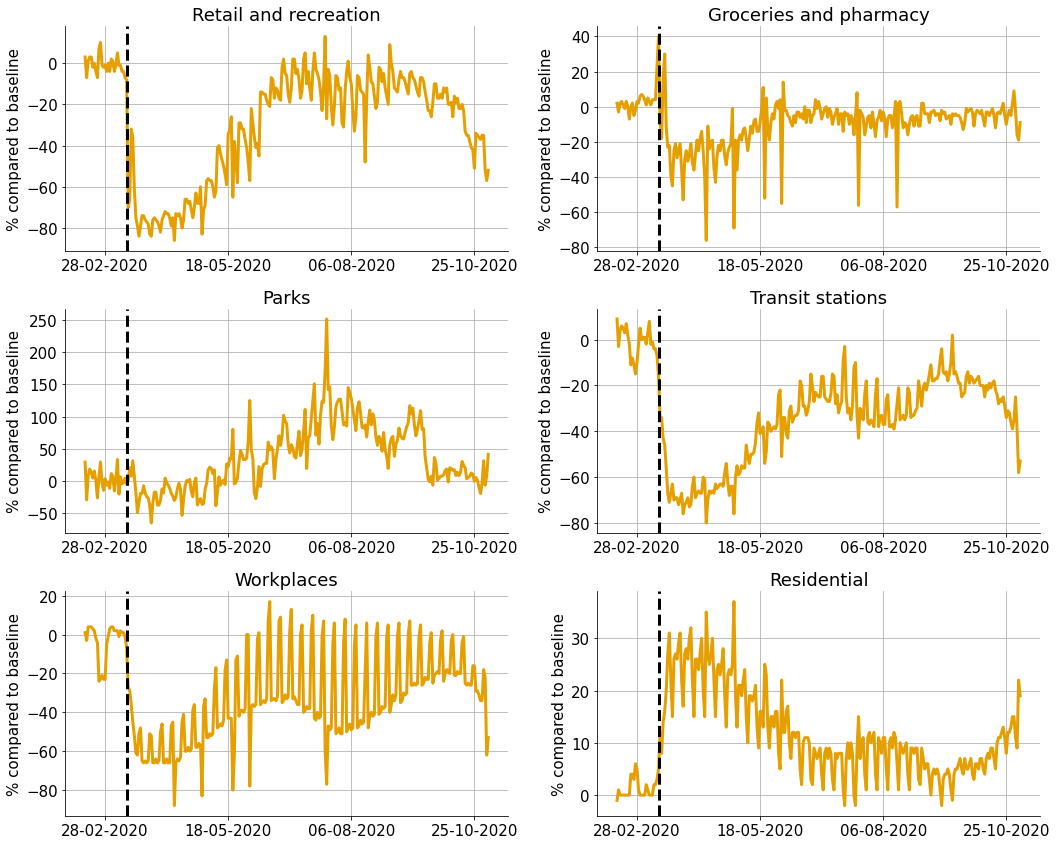

In [6]:
df_google = google.get_google_mobility_data(update=False, plot=True)

### Social interatia and time-dependent parameters

#### Social inertia

The model takes into account the effect of *social inertia* when measures are taken. In reality, social restrictions or relaxations represent a change in behaviour which is gradual and cannot be modeled using a step-wise change of the social interaction matrix $\mathbf{N_c}$. This can be seen when closely inspecting the *Google community mobility report* above. Multiple functions can be used to model the effects of social compliance, e.g. a delayed or non-delayed ramp, or a logistic function. In our model, we use a delayed ramp to model compliance, 

\begin{equation}
\mathbf{N_{c}}^{k} = \mathbf{N_{\text{c, old}}} + f^{k} (\mathbf{N_{\text{c, new}}} - \mathbf{N_{\text{c, old}}})
\end{equation}

where,
\begin{equation}
    f^k= 
\begin{cases}
	0.0,& \text{if } k\leq \tau\\
    \frac{k}{l} - \frac{\tau}{l},& \text{if } \tau < k\leq \tau + l\\
    1.0,              & \text{otherwise}
\end{cases}
\end{equation}

where $\tau$ is the number of days before measures start having an effect and $l$ is the number of additional days after the time delay until full compliance is reached. Both parameters were calibrated to the daily number of hospitalizations in Belgium (notebooks `notebooks/0.1-twallema-calibration-deterministic.ipynb` and `notebooks/0.1-twallema-calibration-stochastic.ipynb`). $k$ denotes the number of days since a change in social policy.

#### The use of time-dependent parameters

Any model parameter can be altered during the course of a simulation by defining a time dependent parameter function. The function below is applied to the interaction matrix $\mathbf{N}_C$. On the time `policy_time`, the interaction matrix is altered from a value `policy1` to `policy2` according to the delayed ramp compliance model with parameters `l` and `tau`. The prevention parameter ($\Omega$) can be used to 'downgrade' the weight of the social contacts under lockdown measures.

In [7]:
from covid19model.models.time_dependant_parameter_fncs import lockdown_func
from covid19model.models.utils import draw_sample_COVID19_SEIRD

### Basic reproduction number

The basic reproduction number $R_0$, defined as the expected number of secondary cases directly generated by one case in a population where all individuals are susceptible to infection, is computed using the next generation matrix (NGM) approach introducted by Diekmann. For our model, the basic reproduction number of age group $i$ is,
\begin{equation}\label{eq:reproduction_number}
R_{0,i} = (a_i d_a + \omega) \beta s_i \sum_{j=1}^{N} N_{c,ij}
\end{equation}
and the population basic reproduction number is calculated as the weighted average over all age groups using the demographics of Belgium. The detailed algebra underlying the computation equation of the basic reproduction number is presented in the supplementary materials of our manuscript (https://www.medrxiv.org/content/10.1101/2020.07.17.20156034v2).

### Model parameters

<img src="../../docs/_static/figs/parameters.png" alt="parameters" width="900"/>

## Simulations with the deterministic model

### Model initialization

In [8]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
               'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date': pd.to_datetime('2020-03-15')})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func})

### Load posterior parameter distributions of calibrated parameters

Both the deterministic and stochastic model were calibrated to the national hospitalization data provided by the Scientific Institute of Public Health (Sciensano). 


The parameters $\beta$, $l$, $\tau$ and $\Omega$ were calibrated.

The aim of such a calibration is to obtain a parameter set which leads to a good agreement between the model predictions and the experimental data. Five timeseries starting on Sunday, March 15th, 2020 have been made publically available by the Belgian Scientific Institute of Public Health (Sciensano),

- the total number of patients in the hospitals ($H_{\text{tot}}$)
- the total number of patients in ICU ($ICU_{\text{tot}}$)
- the daily hospitalizations ($H_{\text{in}}$)
- the daily hospital discharges ($H_{\text{out}}$)
- the daily number of deaths ($D_{\text{new}}$)

We assume the timeseries are independent and identically distributed (i.d.d.) sequences of normal random variables having a mean $\hat{y}(k)$ and an unknown variance $\hat{\sigma}^2$. The resulting log-likelihood function is,

\begin{equation}
\ln \big( P( y \mid \mathbf{\hat{\theta}}) \big) = - \frac{1}{2} \sum_{k=1}^{N} \Bigg[ \frac{\big(y(k) - \hat{y}(k, \mathbf{\hat{\theta}})\big)^2}{\hat{\sigma}^2} + \ln\big(2 \pi \hat{\sigma}^2\big) \Bigg]\ ,
\end{equation}

where $\mathbf{\hat{\theta}}$ and $\hat{\sigma}^2$ are computed to maximize the log-likelihood function. The fitting procedure is performed in two steps. First, the transmission parameter $\beta$ is calibrated using the daily hospitalizations from March 15th, 2020 until March 22nd, 2020. These data are used because they do not depend on the durations of the hospitalizations, $d_c$ and $d_{\text{ICU}}$, which are computed from the limited and imperfect hospital dataset. In addition to the calibration of the transmission parameter $\beta$, the number of days between the first infectious individuals entering the country and the onset of data collection (March 15th, 2020) must be estimated. The latter is denoted as excess time, $t_e$. Second, the daily hospitalizations ($H_{\text{in}}$) from March 15th, 2020 until April 20th, 2020 were used to infer the slope of the compliance ramp ($l$), as well as the effect of prevention measures and *network* effects in the workplace and on public transport ($\Omega$).

We performed the above optimizations in two steps. First, we used a particle swarm optimization (PSO) algorithm to scan the parameter space and find the global maximum likelihood. We then used the obtained maximum-likelihood estimates as initial values for the ensemble sampler for Markov Chain Monte Carlo (MCMC) proposed by Goodman 2010. For all parameters, uniform prior distributions were used. The sampler was always run on $2n$ parallel chains, were $n$ was the number of parameters to be sampled from the posterior distributions. For each chain, we drew at least 50-fold more samples than the autocorrelation time. Next, we visualised the samples using the scatterplot matrix proposed by Foreman (2016), further referred to as *cornerplot*. In these visualizations, each one- and two-dimensional projection of the sample is plotted to reveal correlations. During each step of the optimization procedure, previously sampled parameters were propagated.

The calibration can be found in the notebook `notebooks/0.1-twallema-calibration-deterministic.ipynb`. The posterior samples of the calibrated parameters can be found in `data/interim/model_parameters/deterministic_22072020.json`.

In [9]:
# Scrape the publically available data from the Scientific institute of Public Health (Sciensano)
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-11-04,7405,1412,653,673,5939,186,0.0,14.0,32,57,83
2020-11-05,7288,1428,559,660,5838,184,0.0,12.0,26,57,88
2020-11-06,7221,1459,593,626,5805,168,0.0,11.0,30,53,74
2020-11-07,6888,1464,500,745,5560,131,1.0,9.0,20,47,53
2020-11-08,6948,1469,400,294,5666,26,1.0,3.0,3,7,12


In [10]:
# Load previous samples
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/classical/BE_2020-11-05.json', 'r') as fp:
    samples_dict = json.load(fp)

### Simulating

A simulation is run by using the attribute function *sim*, which uses one argument, the simulation time, as its input. 

```
out = model.sim(100)
```

The snippet above would run a 100 day simulation with the initialized model. However, to make predictions on how COVID-19 will spread it is more convenient to have the simulation time as dates, rather than integer numbers. The snippet above will NOT work in conjuction with the time-varying policy implemented in `lockdown_func`. To perform a simulation using datetimes, the end date of the simulation is given as the first argument of the `sim` function. Next, the start date of data collection must be defined, for Belgium this is March 15th, 2020. 

As an initial condition, we use one exposed individual in every age group. This implies the simulation must be run for some time between its start, and the start of data collection on March 15th, 2020. In our code, this concept is named `warmup` and was calibrated to high-level Belgian hospitalization data. 

In [1]:
out=model.sim('2020-09-01',start_date='2020-03-15',warmup=samples_dict['warmup'])

NameError: name 'model' is not defined

#### Extracting model output

The output format of the deterministic and stochastic model are an `xarray` dataset. This flexible python package introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays. Relevant to our work are the coordinates,
1. 'stratification': the nine different age groups used in the model.
2. 'time': simulation time

and the data variables, which are the 11 model states (S,E,I,...,R,D). Future work will include a spatial extension, which will simply use a new coordinate 'NIS'.

In [12]:
out

<xarray.Dataset>
Dimensions:   (Nc: 9, time: 222)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-24 2020-01-25 ... 2020-09-01
  * Nc        (Nc) int64 0 1 2 3 4 5 6 7 8
Data variables:
    S         (Nc, time) float64 1.269e+06 1.269e+06 ... 6.468e+05 6.468e+05
    E         (Nc, time) float64 1.0 0.7583 0.62 0.5464 ... 3.292 3.183 3.078
    I         (Nc, time) float64 0.0 0.2111 0.2944 0.3202 ... 2.206 2.133 2.062
    A         (Nc, time) float64 0.0 0.04069 0.1215 0.2081 ... 3.13 3.026 2.926
    M         (Nc, time) float64 0.0 0.01662 0.04964 0.085 ... 7.136 6.901 6.672
    ER        (Nc, time) float64 0.0 7.292e-07 4.268e-06 ... 0.7764 0.7507
    C         (Nc, time) float64 0.0 6.765e-08 8.227e-07 ... 2.4 2.321 2.244
    C_icurec  (Nc, time) float64 0.0 0.0 0.0 0.0 ... 0.313 0.3027 0.2928 0.2831
    ICU       (Nc, time) float64 0.0 0.0 0.0 0.0 ... 0.8973 0.8677 0.8391 0.8115
    R         (Nc, time) float64 0.0 0.00295 0.01897 ... 9.215e+03 9.216e+03
    D         (Nc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 766.2 766.4 766.6 766.7
    H_in      (Nc, time) float64 0.0 6.265e-07 3.202e-06 ... 0.2685 0.2598 0.251
    H_out     (Nc, time) float64 0.0 1.509e-09 3.284e-08 ... 0.4069 0.3934
    H_tot     (Nc, time) float64 0.0 7.968e-07 5.091e-06 ... 4.374 4.229 4.089
Attributes:
    parameters:  {'beta': 0.03492, 'sigma': 3.2, 'omega': 2.0, 'zeta': 0.0, '...

As an example of output handling, consider the following simple code snippet. Here, the total number of patients in Belgian ICUs over time is given. Summing over all age groups is simple.

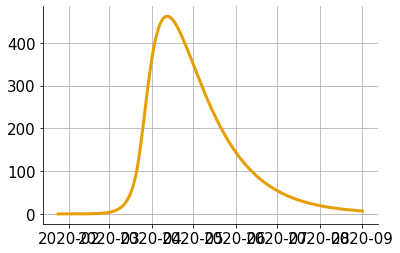

In [13]:
plt.plot(out['time'],out['ICU'].sum(dim='Nc'))

#### Visualizing the results using builtin methods

Two custom visualization routines are included in `src/covid19model/visualization/output.py` for rapid prototyping, `infected` and `population_status`. For more details, we refer to the docstring in the aforementioned python script.

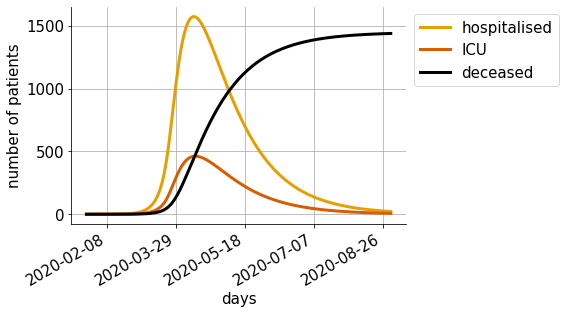

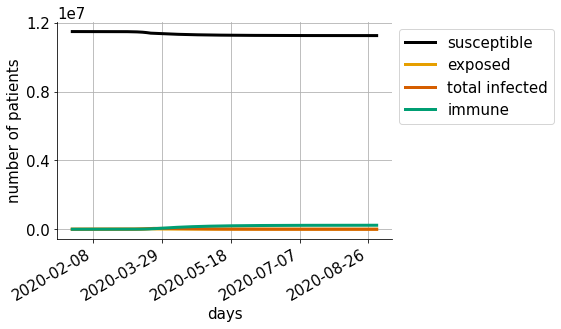

In [14]:
infected(out)
population_status(out)

#### Using posterior samples from previously calibrated parameters to quantify uncertainty

In [15]:
out = model.sim('2020-09-01',start_date='2020-03-15',excess_time=samples_dict['warmup'],N=20,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

In [16]:
out

<xarray.Dataset>
Dimensions:   (Nc: 9, draws: 20, time: 222)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-24 2020-01-25 ... 2020-09-01
  * Nc        (Nc) int64 0 1 2 3 4 5 6 7 8
Dimensions without coordinates: draws
Data variables:
    S         (draws, Nc, time) float64 1.269e+06 1.269e+06 ... 6.338e+05
    E         (draws, Nc, time) float64 1.0 0.7607 0.628 ... 1.231 1.175 1.122
    I         (draws, Nc, time) float64 0.0 0.2113 0.2959 ... 0.8095 0.7728
    A         (draws, Nc, time) float64 0.0 0.04071 0.1218 ... 1.362 1.3 1.241
    M         (draws, Nc, time) float64 0.0 0.01663 0.04975 ... 3.115 2.974 2.84
    ER        (draws, Nc, time) float64 0.0 7.294e-07 ... 0.3484 0.3326
    C         (draws, Nc, time) float64 0.0 6.766e-08 8.234e-07 ... 1.184 1.131
    C_icurec  (draws, Nc, time) float64 0.0 0.0 0.0 0.0 ... 0.2243 0.2143 0.2047
    ICU       (draws, Nc, time) float64 0.0 0.0 0.0 0.0 ... 0.5779 0.552 0.5272
    R         (draws, Nc, time) float64 0.0 0.002951 ... 2.118e+04 2.119e+04
    D         (draws, Nc, time) float64 0.0 0.0 0.0 ... 1.765e+03 1.765e+03
    H_in      (draws, Nc, time) float64 0.0 6.267e-07 ... 0.1133 0.1083
    H_out     (draws, Nc, time) float64 0.0 1.509e-09 ... 0.2248 0.2147
    H_tot     (draws, Nc, time) float64 0.0 7.971e-07 5.097e-06 ... 2.299 2.195
Attributes:
    parameters:  {'beta': array([0.03808661]), 'sigma': 3.2, 'omega': 2.0, 'z...

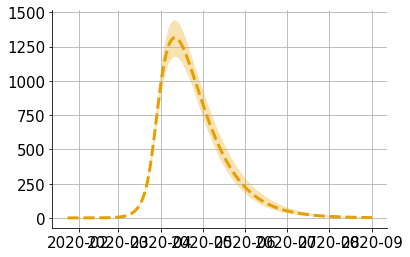

In [17]:
plt.fill_between(pd.to_datetime(out["time"].values), out["ICU"].quantile(0.05,dim="draws").sum(dim="Nc"), out["ICU"].quantile(0.95,dim="draws").sum(dim="Nc"),alpha=0.30)
plt.plot(out["time"],out["ICU"].mean(dim="draws").sum(dim="Nc"),'--')

## Simulations with the stochastic model

### Model initialization

When initializing the stochastic model, a flag `discrete` must be used to switch from the integrator to the iterator.

In [18]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Add the delayed ramp parameters and policy changes during lockdown to model parameters dictionary
params.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
               'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date': pd.to_datetime('2020-03-15')})
# Define the initial condition: ten exposed inidividual in every age category
# Why 10? When only using one exposed, there is a big chance the chain will go extinct!
initial_states = {'S': initN, 'E': 3*np.ones(levels)}
# Initialize the model, the only difference with the stochastic model is the `discrete` flag
model = models.COVID19_SEIRD_sto(initial_states, params, discrete=True, time_dependent_parameters={'Nc': lockdown_func})

### Load posterior parameter distributions of calibrated parameters

The calibration procedure was exactly the same as for the deterministic model. For more details we refer to the calibration notebook, located in `notebooks/0.1-twallema-calibration-stochastic` . The posterior distributions are located in `data/interim/model_parameters/stochastic_15-08-2020.json`.

#### We'll use the deterministic samples, as no calibration of the stochastic variant is currently available.

### Simulating

After the model initialization, the code works in the exact same way as the deterministic model.

In [ ]:
out = model.sim('2020-09-01',start_date='2020-03-15',excess_time=samples_dict['warmup'],N=100,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

In [ ]:
plt.fill_between(pd.to_datetime(out["time"].values), out["ICU"].quantile(1-0.95,dim="draws").sum(dim="Nc"), out["ICU"].quantile(0.95,dim="draws").sum(dim="Nc"),alpha=0.20,color='blue')
plt.fill_between(pd.to_datetime(out["time"].values), out["ICU"].quantile(1-0.68,dim="draws").sum(dim="Nc"), out["ICU"].quantile(0.68,dim="draws").sum(dim="Nc"),alpha=0.80,color='blue')
#plt.plot(pd.to_datetime(out["time"].values),out["ICU"].mean(dim="draws").sum(dim="Nc"),'--',color='blue')